In [1]:
#data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import math

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.offline as py

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import gc

from sklearn import metrics
import time
import datetime

#NLP
import nltk
from nltk.corpus import stopwords
import re
import string
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk import word_tokenize
stop = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
from nltk.stem.porter import PorterStemmer


In [2]:
data_train = pd.read_csv('Tweets_dataset/train.csv')

In [3]:
data_test = pd.read_csv('Tweets_dataset/test.csv')

In [4]:
len(data_train)

7613

In [5]:
data_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


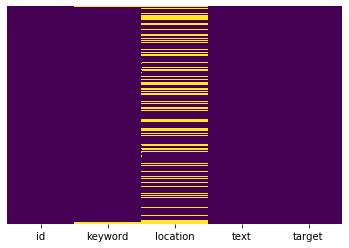

In [6]:
#Missing Values
sns.heatmap(data_train.isnull(),yticklabels = False,cbar = False,cmap = 'viridis')

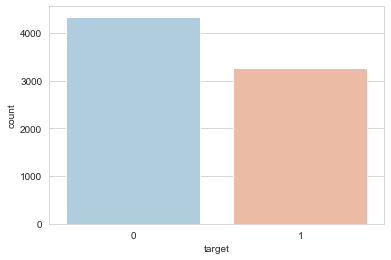

In [7]:
# Good Practice: Always check if data set is balance or imbalance.
sns.set_style('whitegrid')
sns.countplot(x='target',data=data_train,palette='RdBu_r')

Data Cleaning

In [8]:
df=pd.concat([data_train,data_test])
df.shape

c:\users\adeel\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




(10876, 5)

In [9]:
ps = PorterStemmer()
corpus = []
def tokenize(text):
    
    try: 
        #Removing urls
        url_regex = re.compile(r'https?://\S+|www\.\S+')
        text = url_regex.sub(r'',text)
        #Html Tags
        HtmlTags_regex = re.compile(r'<.*?>')
        text = HtmlTags_regex.sub(r'',text)
        #remove emojis
        emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
        text = emoji_pattern.sub(r'', text)
        # remove punctuatio
        regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        text = regex.sub(" ", text)
        
        
        #tokens_ = [word_tokenize(s) for s in sent_tokenize(text)]
        #tokens_ = [lemmatizer.lemmatize(word) for word in tokens_ if word not in set(stopwords.words('english'))]
        #tokens_ = [ps.stem(word) for word in tokens_ if not word in stopwords.words('english')]
        #tokens = []
        #for token_by_sent in tokens_:
            #tokens += token_by_sent
        #tokens = list(filter(lambda t: t.lower() not in stop, tokens))
        #filtered_tokens = [w for w in tokens if re.search('[a-zA-Z]', w)]
        #filtered_tokens = [w.lower() for w in filtered_tokens if len(w)>=3]
        #corpus.append(filtered_tokens)
        #return filtered_tokens
        return text
            
    except TypeError as e: print(text,e)

In [10]:
df['text'] = df['text'].map(tokenize)
#data_test['text'] = data_test['item_description'].map(tokenize)

In [11]:
df.head()

,id,keyword,location,target,text
0,1,NaN,NaN,1.0,Our Deeds are the Reason of this earthquake M...
1,4,NaN,NaN,1.0,Forest fire near La Ronge Sask Canada
2,5,NaN,NaN,1.0,All residents asked to shelter in place are ...
3,6,NaN,NaN,1.0,people receive wildfires evacuation or...
4,7,NaN,NaN,1.0,Just got sent this photo from Ruby Alaska as ...


In [12]:
#!pip install pyspellchecker

In [13]:
from spellchecker import SpellChecker
from tqdm import tqdm
spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [14]:
#df['text1']=df['text'].apply(lambda x : correct_spellings(x))

In [15]:
from tqdm import tqdm
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

In [16]:
corpus=create_corpus(df)

100%|██████████████████████████████████████████████████████████████████████████| 10876/10876 [00:01<00:00, 5770.32it/s]


In [24]:
embedding_dict={}
with open('glove/glove.6B.100d.txt',encoding="utf8") as f: #,'r'
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [26]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

Using TensorFlow backend.


In [27]:
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [28]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 20200


In [29]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|████████████████████████████████████████████████████████████████████████| 20200/20200 [00:00<00:00, 354604.49it/s]


In [30]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           2020100   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 2,062,405
Trainable params: 42,305
Non-trainable params: 2,020,100
_________________________________________________________________


In [32]:
train=tweet_pad[:data_train.shape[0]]
test=tweet_pad[data_train.shape[0]:]

In [33]:
X_train,X_test,y_train,y_test=train_test_split(train,data_train['target'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6471, 50)
Shape of Validation  (1142, 50)


In [34]:
history=model.fit(X_train,y_train,batch_size=4,epochs=15,validation_data=(X_test,y_test),verbose=2)

Train on 6471 samples, validate on 1142 samples
Epoch 1/15
 - 29s - loss: 0.6916 - accuracy: 0.5712 - val_loss: 0.6903 - val_accuracy: 0.5613
Epoch 2/15
 - 26s - loss: 0.6845 - accuracy: 0.5724 - val_loss: 0.6666 - val_accuracy: 0.5657
Epoch 3/15
 - 27s - loss: 0.6164 - accuracy: 0.6801 - val_loss: 0.5449 - val_accuracy: 0.7688
Epoch 4/15
 - 26s - loss: 0.5852 - accuracy: 0.7200 - val_loss: 0.5258 - val_accuracy: 0.7706
Epoch 5/15
 - 26s - loss: 0.5644 - accuracy: 0.7347 - val_loss: 0.5146 - val_accuracy: 0.7767
Epoch 6/15
 - 26s - loss: 0.5630 - accuracy: 0.7374 - val_loss: 0.5075 - val_accuracy: 0.7802
Epoch 7/15
 - 26s - loss: 0.5530 - accuracy: 0.7450 - val_loss: 0.5020 - val_accuracy: 0.7793
Epoch 8/15
 - 26s - loss: 0.5497 - accuracy: 0.7535 - val_loss: 0.4980 - val_accuracy: 0.7846
Epoch 9/15
 - 26s - loss: 0.5510 - accuracy: 0.7492 - val_loss: 0.4962 - val_accuracy: 0.7855
Epoch 10/15
 - 26s - loss: 0.5382 - accuracy: 0.7594 - val_loss: 0.4924 - val_accuracy: 0.7890
Epoch 11/15

In [36]:
sample_sub=pd.read_csv('Tweets_dataset/sample_submission.csv')

In [38]:
y_pre=model.predict(test)
y_pre=np.round(y_pre).astype(int).reshape(3263)
sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':y_pre})
sub.to_csv('Tweets_dataset/submission_1.csv',index=False)

In [39]:
sub.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
